In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline

In [170]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [171]:
match_ids = matches[matches.season >= 2016]['id'].unique()

In [172]:
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [173]:
team_1 = 'Royal Challengers Bangalore'
team_2 = 'Kings XI Punjab'

In [174]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

# Winning Chances of Teams

Text(0.5, 1.0, 'Percentage of Winning')

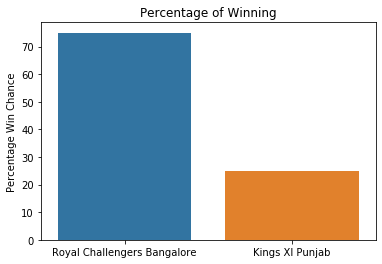

In [175]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
sns.barplot(wins.index, y=wins['Percentage Win Chance'])
plt.title('Percentage of Winning')

In [176]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

In [177]:
k11p_bowler_squad = ['CJ Jordan', 'A Singh', 'Mohammed Shami', 'K Gowtham', 'Mandeep Singh', 'GJ Maxwell']
rcb_bowler_squad = ['YS Chahal', 'N Saini', 'CH Morris', 'S Dube', 'Mohammed Siraj']
partners = ['V Kohli', 'AB de Villiers']

# Wickets lose by KXIP 

In [178]:
k11p_wk = delivery[(delivery['batting_team']==team_2)].groupby('match_id').sum()
avg_k11p_wk = k11p_wk['player_dismissed'].median()
print("Average wickets taken of {}: ".format(team_2), avg_k11p_wk)

Average wickets taken of Kings XI Punjab:  6.0


# Patnership Runs of Kohli and de Villiers

Text(29, 43.63793103448276, 'Average Partnership of V Kohli and AB de Villiers: 43 runs')

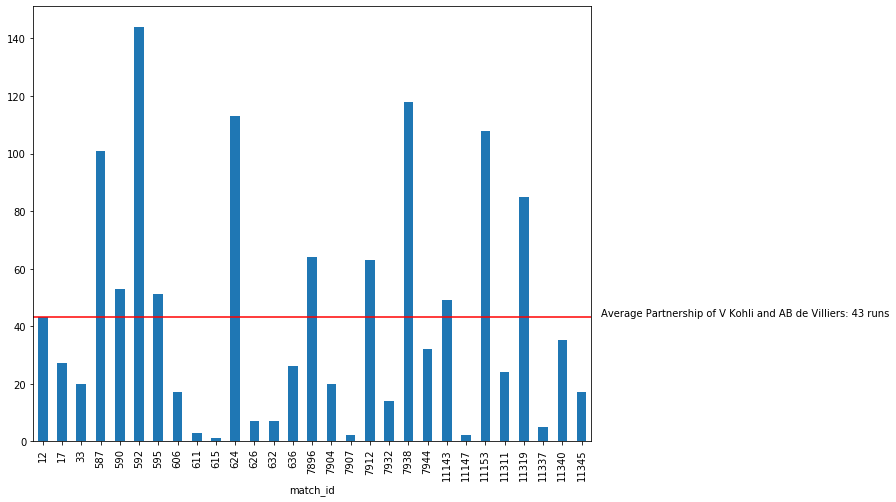

In [179]:
partners_against_all = delivery[(delivery['batsman'].isin(partners)) & (delivery['non_striker'].isin(partners))].groupby('match_id').sum()
partners_against_all = partners_against_all[partners_against_all['batsman_runs']<150]
plt.figure(figsize=(10,8))
partners_mean = partners_against_all['batsman_runs'].mean()
partners_against_all['batsman_runs'].plot(kind='bar')
plt.axhline(y=partners_mean, color='red')
plt.text(x=29, y=partners_mean+0.5, fontsize=10, s="Average Partnership of V Kohli and AB de Villiers: {} runs".format(math.floor(partners_mean)))

# Number of sixes

In [180]:
groupby_rcb_sixes = (delivery[(delivery['batting_team'] == team_1)& (delivery['batsman_runs']==6)].groupby('match_id').sum())
groupby_k11p_sixes = (delivery[(delivery['batting_team'] == team_2)& (delivery['batsman_runs']==6)].groupby('match_id').sum())
pred_k11p_sixes = (groupby_k11p_sixes['batsman_runs']/6).describe()[5]
pred_rcb_sixes = (groupby_rcb_sixes['batsman_runs']/6).describe()[6]
print("Since, probability of sixes is very high in Sharjah, we take the number of sixes hit by both teams once in a match which lies among top 25% of highest sixes range")
print("So, predicted number of sixes for match between RCB and KXIP is {}".format(pred_k11p_sixes+pred_rcb_sixes))

Since, probability of sixes is very high in Sharjah, we take the number of sixes hit by both teams once in a match which lies among top 25% of highest sixes range
So, predicted number of sixes for match between RCB and KXIP is 16.0


# Number of No-balls

In [181]:
bowler_squad = rcb_bowler_squad + k11p_bowler_squad

In [183]:
bowlers_noball = dict()
for bowler in bowler_squad:
    no_of_no_balls_per_match = (delivery[delivery['bowler']==bowler].groupby('match_id').sum()['noball_runs']).mean()
    bowlers_noball[bowler] = no_of_no_balls_per_match

print("Number of No-balls predicted :", round(sum(bowlers_noball.values())))

Number of No-balls predicted : 1


# Summary

- Data was cleaned and filtered. The data from year 2016 to 2019 was taken and all the non-required columns were dropped. 
- Using the "winner" column of the dataset, the percentage chances of winning between RCB and KXIP was calculated.
- The general number of wickets lost by KXIP in a match was calculated by taking out the median number of wickets KXIP generally loose in a match.
- Using the bastman and non-stricker columns, the partnership of V Kohli and AB de Villiers was taken out per match and then averaged.
- The third quantile value of both the teams in case of their sixes per match was taken and added to estimate number of sixes in today's match. The reason was because today's stadium is small and ground dimensions are small which creates high probability of sixes. 
- Average no-balls runs per bowler per match was taken and added to estimate number of no balls in today's match. 